# Capstone Project — The Battle of Neighbourhoods

## Introduction

New Delhi is the capital city of India. The city itself has a population of 257,803. However, the much larger metro area has a population that exceeds 26 million. With its diverse culture, comes diverse food items. There are many restaurants in New Delhi, each belonging to different categories like Chinese, Italian, French, Mughlai, North Indian etc.

So in this project, we will list and visualize all major parts of the city and find out which part is the go-to place for Italian food so that a future restaurateur who wants to open an Italian cuisine restaurant can find the best part of the city in which the demand for Italian cuisine is very high.

I would need to use Foursquare location data to find out the ratings, reviews and other information to make a good analysis of the data that I have and create an efficient cluster model.


## Questions a future restaurateur might ask if he/she were to open an Italian cuisine restaurant in New Delhi

•	Which areas have largest demand for Italian Cuisine?

•	Which areas have fewer number of restaurants?

•	What is best location in New Delhi City to open a Italian Cuisine restaurant? 


## Data

For this project we need the following data:

Delhi Neighborhood Dataset that contains a list of sort Borough, Neighborhood, latitude and longitude.

Data source: Delhi Neighborhood Dataset
Dataset: https://www.kaggle.com/shaswatd673/delhi-neighborhood-data

This data set contains the required information. And we will use this data set to explore various neighborhoods  of New Delhi city.

Nearby places in each locality of New Delhi city.

Data source: Foursquare API: "https://developer.foursquare.com/"
By using this API, we will get all the venues, reviews and ratings of each neighbourhood.


## Approach

•	Collect the necessary the New Delhi city data from Delhi Neighborhood Dataset that we downloaded from Kaggle

•	Using Foursquare API, we will find all venues for each neighbourhood.

•	Filter out all venues that are nearby by locality.

•	Using aggregative rating for each restaurant to find the best places for Italian cuisine.

•	Visualize the best neighbourhoods for the new restaurant using folium library on a map


## Lets install all the libraries that we will require in this project

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score
# Matplotlib and associated plotting modules
import seaborn as sns
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # import folium library for maps
import folium # map rendering library


In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/arzkar/IBM-Advanced-Data-Science-Capstone/master/Docs%20%26%20CSVs/delhi_dataset.csv')
df.head()

,Unnamed: 0,Borough,Neighborhood,Latitude,Longitude
0,0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,2,North West Delhi,Azadpur,28.707657,77.175547
3,3,North West Delhi,Bawana,28.799660,77.032885
4,4,North West Delhi,Begum Pur,28.723900,77.060900


## Data Cleaning
Removing the unwanted columns and rows from dataset

In [7]:
del df['Unnamed: 0']
df.reset_index(drop=True, inplace=True)
labels=df['Neighborhood']
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Azadpur,28.707657,77.175547
3,North West Delhi,Bawana,28.799660,77.032885
4,North West Delhi,Begum Pur,28.723900,77.060900


## Create a map to show the restaurants in New Delhi

In [23]:
ND_map = folium.Map(location=[28.52, 77.25], zoom_start=12)
for latitude, longitude, neighborhood, borough in zip(df['Latitude'], df['Longitude'],df['Neighborhood'],df['Borough']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,parse_html=False).add_to(ND_map)  

ND_map

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [4]:
CLIENT_ID = 'YXY2NVS53N4F1PGNPHPEQATEAVSN2XUEBM4CMCGFNU54MAM0' # your Foursquare ID
CLIENT_SECRET = 'TGKVQ43C2K1IOBSYJP3F3KV15DA5SYY4ECLW4V1FDAVMGZ5Q' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Let's create a function to repeat the process of getting the venues to all the neighborhoods in New Delhi

In [8]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        radius=1000  
        LIMIT=1000
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *delhi_venues*.

In [7]:
delhi_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Adarsh Nagar
Ashok Vihar
Azadpur
Bawana
Begum Pur
Jahangirpuri
Karala
Keshav Puram
Kingsway Camp
Kohat Enclave
Model Town
Narela
Pitam Pura
Rani Bagh
Rithala
Rohini
Shalimar Bagh
Shakti Nagar
Bara Hindu Rao
Chandni Chowk
Chawri Bazaar
Civil Lines
Dariba Kalan
Gulabi Bagh
Kamla Nagar
Kashmiri Gate
Kotwali
Lahori Gate
Nehru Vihar
Paharganj
Pratap Nagar
Pul Bangash
Roshanara Bagh
Sadar Bazaar
Sangam Vihar
Sant Nagar
Sarai Kale Khan
Sarai Rohilla
Shakti Nagar
Shastri Nagar
Tis Hazari
Timarpur
Wazirabad
Babarpur
Dilshad Garden
Kabir Nagar
Mandoli
Maujpur
Nand Nagri
Naveen Shahdara
New Usmanpur
Shahdara
Sonia Vihar
Shastri Park
Yamuna Vihar
Chandni Chowk
Daryaganj
Jhandewalan
Karol Bagh
Bara Hindu Rao
Paharganj
Rajinder Nagar
Sadar Bazaar
Barakhamba Road
Chanakyapuri
Connaught Place
Gautampuri
Gole Market
Golf Links
INA Colony
Khan Market
Laxmi Bai Nagar
Pragati Maidan
Brij Puri
East Vinod Nagar
Gandhi Nagar
Geeta Colony
Jhilmil Colony
Krishna Nagar
Laxmi Nagar
Mayur Vihar
Pandav Nagar
Patpa

#### Let us save the venues data into a CSV file so that we can use it later if we want

In [ ]:
delhi_venues.to_csv("delhi_venues.csv", index=False)

In [8]:
delhi_venues=pd.read_csv('https://raw.githubusercontent.com/arzkar/IBM-Advanced-Data-Science-Capstone/master/Docs%20%26%20CSVs/delhi_venues.csv')

#### Let's check the size of the resulting dataframe

In [9]:
print(delhi_venues .shape)
delhi_venues.head()

(3315, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,28.614193,77.071541,Bikanerwala,28.613391,77.076084,Indian Restaurant
1,Adarsh Nagar,28.614193,77.071541,Uttam nagar,28.620201,77.068709,Metro Station
2,Adarsh Nagar,28.614193,77.071541,Gold's Gym A Block Janakpuri,28.622439,77.069348,Gym
3,Adarsh Nagar,28.614193,77.071541,Potholes at Dabri,28.605309,77.072504,Pool
4,Ashok Vihar,28.699453,77.184826,Bellagio,28.696361,77.180021,Asian Restaurant


Let's check how many venues were returned for each neighborhood

In [127]:
delhi_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adarsh Nagar,4,4,4,4,4,4
Alaknanda,28,28,28,28,28,28
Anand Vihar,13,13,13,13,13,13
Ashok Nagar,30,30,30,30,30,30
Ashok Vihar,9,9,9,9,9,9
...,...,...,...,...,...,...
Vishwas Nagar,6,6,6,6,6,6
Vivek Vihar,10,10,10,10,10,10
Wazirabad,9,9,9,9,9,9


#### Let's find out how many unique categories can be curated from all the returned venues

In [128]:
print('There are {} uniques categories.'.format(len(delhi_venues['Venue Category'].unique())))

There are 214 uniques categories.


## Lets analyze each Neighborhood

In [10]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhood'] = delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
first_col = delhi_onehot.pop('Neighborhood')
delhi_onehot.insert(0,'Neighborhood', first_col)

delhi_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Train Station,Turkish Restaurant,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Zoo
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ashok Vihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [130]:
delhi_onehot.shape

(3315, 214)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [11]:
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()
delhi_grouped

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Train Station,Turkish Restaurant,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wings Joint,Women's Store,Zoo
0,Adarsh Nagar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaknanda,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anand Vihar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.076923,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ashok Nagar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ashok Vihar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Vishwas Nagar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,Vivek Vihar,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
167,Wazirabad,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168,Yamuna Vihar,0.6,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Let's confirm the new size

In [132]:
delhi_grouped.shape

(170, 214)

#### Let's print each neighborhood along with the top 5 most common venues

In [12]:
num_top_venues = 5

for hood in delhi_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = delhi_grouped[delhi_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adarsh Nagar----
               venue  freq
0               Pool  0.25
1  Indian Restaurant  0.25
2                Gym  0.25
3      Metro Station  0.25
4             Office  0.00


----Alaknanda----
               venue  freq
0        Coffee Shop  0.14
1         Restaurant  0.11
2          BBQ Joint  0.07
3             Market  0.07
4  Indian Restaurant  0.07


----Anand Vihar----
                  venue  freq
0  Fast Food Restaurant  0.15
1     Indian Restaurant  0.15
2                Arcade  0.08
3        Ice Cream Shop  0.08
4   Fried Chicken Joint  0.08


----Ashok Nagar----
                  venue  freq
0  Fast Food Restaurant  0.17
1            Food Court  0.07
2                  Café  0.07
3           Coffee Shop  0.07
4         Shopping Mall  0.07


----Ashok Vihar----
                  venue  freq
0           Coffee Shop  0.11
1     Indian Restaurant  0.11
2        Sandwich Place  0.11
3  Fast Food Restaurant  0.11
4      Asian Restaurant  0.11


----Azadpur----
           

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [14]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
delhi_venues_sorted = pd.DataFrame(columns=columns)
delhi_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]): 
    delhi_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

delhi_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Metro Station,Pool,Indian Restaurant,Gym,Zoo,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
1,Alaknanda,Coffee Shop,Restaurant,Indian Restaurant,Market,BBQ Joint,Chinese Restaurant,Sandwich Place,Café,Thai Restaurant,Park
2,Anand Vihar,Indian Restaurant,Fast Food Restaurant,Soup Place,Arcade,Fried Chicken Joint,Café,Food Court,Ice Cream Shop,Pizza Place,Indian Sweet Shop
3,Ashok Nagar,Fast Food Restaurant,Donut Shop,Coffee Shop,Clothing Store,Restaurant,Café,Shopping Mall,Multiplex,Food Court,Italian Restaurant
4,Ashok Vihar,Pizza Place,Coffee Shop,Snack Place,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Donut Shop,South Indian Restaurant,Indian Restaurant,Discount Store


# Now lets Cluster all the Neighborhoods

Lets use the Silhouette Coefficient Method to select the optimal numbers of cluster

For n_clusters = 2 The average silhouette_score is : 0.34537089756093425
For n_clusters = 3 The average silhouette_score is : 0.36161721119535284
For n_clusters = 4 The average silhouette_score is : 0.10731621632154915
For n_clusters = 5 The average silhouette_score is : 0.06852709610470177
For n_clusters = 6 The average silhouette_score is : 0.08850006684555536
For n_clusters = 7 The average silhouette_score is : 0.05839751089096266
For n_clusters = 8 The average silhouette_score is : 0.042941022532143075


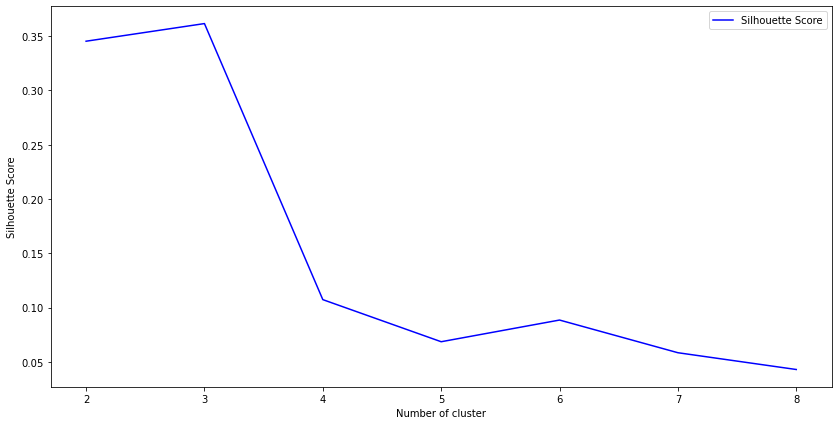

In [19]:
range_n_clusters = [2, 3, 4, 5, 6,7,8]
ss = []
delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)
for n_clusters in range_n_clusters:
   #iterating through cluster sizes
   clusterer = KMeans(n_clusters = n_clusters, random_state=42)
   cluster_labels = clusterer.fit_predict(delhi_grouped_clustering)
   #Finding the average silhouette score
   silhouette_avg = silhouette_score(delhi_grouped_clustering, cluster_labels)
   ss.append(silhouette_avg)
   print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)
fig = plt.figure(figsize=(14,7))
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

From the above plot, we observe that 3 is the optimal number of clusters 

Run *k*-means to cluster the neighborhood into 3 clusters.

In [20]:
# set number of clusters
kclusters = 3
delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [21]:
# add clustering labels
delhi_venues_sorted.insert(0, 'Cluster Labels',kmeans.labels_)
delhi_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(delhi_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
delhi_merged.head(7) # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North West Delhi,Adarsh Nagar,28.614192,77.071541,0,Metro Station,Pool,Indian Restaurant,Gym,Zoo,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
1,North West Delhi,Ashok Vihar,28.699453,77.184826,0,Pizza Place,Coffee Shop,Snack Place,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Donut Shop,South Indian Restaurant,Indian Restaurant,Discount Store
2,North West Delhi,Azadpur,28.707657,77.175547,0,Park,Indian Restaurant,Bus Station,Zoo,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
3,North West Delhi,Bawana,28.799660,77.032885,2,Playground,Zoo,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
4,North West Delhi,Begum Pur,28.723900,77.060900,0,Indian Restaurant,Food Truck,Restaurant,Bakery,Zoo,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Court
5,North West Delhi,Jahangirpuri,28.725972,77.162658,1,ATM,Light Rail Station,Electronics Store,Farmers Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
6,North West Delhi,Keshav Puram,28.688926,77.161683,0,Indian Restaurant,Department Store,Train Station,Snack Place,Shopping Mall,Basketball Court,Fast Food Restaurant,Light Rail Station,Athletics & Sports,Dumpling Restaurant


Finally, let's visualize the resulting clusters

In [25]:
# create map
map_clusters = folium.Map(location=[latitude,longitude], zoom_start=11)
# set color scheme for the clusters
colors = ['red','cyan','green', 'pink', 'blue' ,'white','grey']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['Latitude'], delhi_merged['Longitude'], delhi_merged['Neighborhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Lets examine the Clusters

In [26]:
#Adding 1 to CLuster labels so that that the labels will start from 1 rather than 2
delhi_merged['Cluster Labels']=delhi_merged['Cluster Labels']+1    

### Lets visualize a counterplot using Seaborn to check which Cluster has the most numbers of Italian Restaurants

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

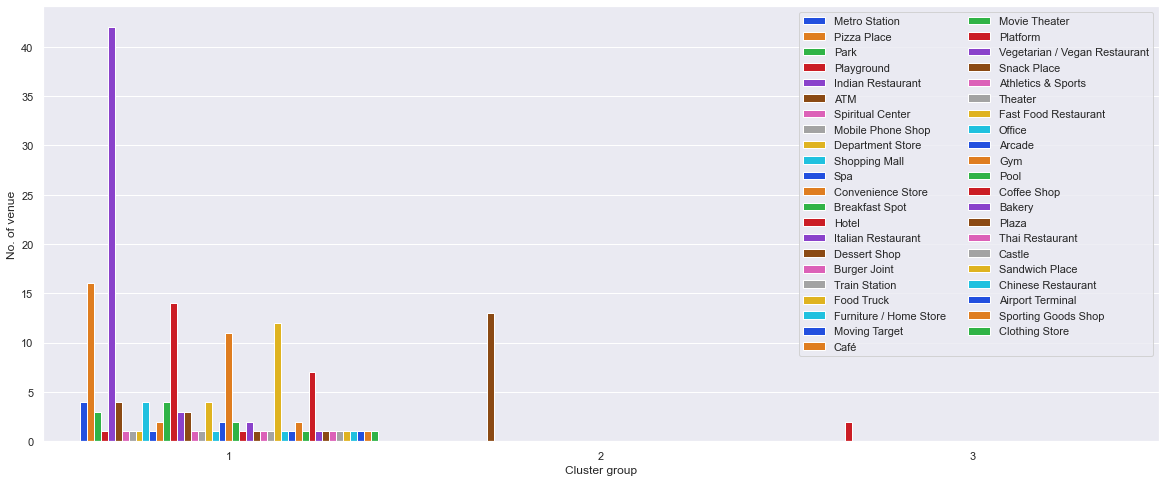

In [27]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,8))
ax = sns.countplot(x="Cluster Labels",hue="1st Most Common Venue", data=delhi_merged, palette='bright',orient='h')
plt.xlabel('Cluster group')
plt.ylabel('No. of venue')
#for i in range(0,5):
 #   plt.axvline(0.5+i,color='black')
ax.legend(ncol=2, loc="upper right", frameon=True)    
plt.plot    

#### From the above plot, we observe that cluster 1 has the highest number of Italian Restaurants

#### Let us examine Cluster 1 in more detail

#### Cluster 1

In [28]:
clus1=delhi_merged.loc[delhi_merged['Cluster Labels'] == 1, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]
clus1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Metro Station,Pool,Indian Restaurant,Gym,Zoo,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
1,Ashok Vihar,Pizza Place,Coffee Shop,Snack Place,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Donut Shop,South Indian Restaurant,Indian Restaurant,Discount Store
2,Azadpur,Park,Indian Restaurant,Bus Station,Zoo,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
4,Begum Pur,Indian Restaurant,Food Truck,Restaurant,Bakery,Zoo,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Court
6,Keshav Puram,Indian Restaurant,Department Store,Train Station,Snack Place,Shopping Mall,Basketball Court,Fast Food Restaurant,Light Rail Station,Athletics & Sports,Dumpling Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
174,Shivaji Place,Fast Food Restaurant,Indian Restaurant,Light Rail Station,Café,Garden,Diner,Hotel,Shopping Mall,Chinese Restaurant,Snack Place
175,Tihar Village,Fast Food Restaurant,Restaurant,Shopping Mall,Multiplex,Café,Donut Shop,Coffee Shop,Indian Restaurant,Gym / Fitness Center,Food Court
176,Tilak Nagar,Clothing Store,Fast Food Restaurant,Furniture / Home Store,Farmers Market,Fried Chicken Joint,Donut Shop,Light Rail Station,Café,Frozen Yogurt Shop,French Restaurant
177,Uttam Nagar,Pizza Place,Train Station,Café,Zoo,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop


#### Cluster 2

In [29]:
clus2=delhi_merged.loc[delhi_merged['Cluster Labels'] == 2, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]
clus2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Jahangirpuri,ATM,Light Rail Station,Electronics Store,Farmers Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
33,Sangam Vihar,ATM,Athletics & Sports,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
47,Nand Nagri,ATM,Recording Studio,Department Store,Accessories Store,Irani Cafe,Event Space,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
49,New Usmanpur,ATM,Circus,Tourist Information Center,Dessert Shop,Diner,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
51,Sonia Vihar,ATM,Garden,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food,Flea Market
52,Shastri Park,ATM,Fast Food Restaurant,Metro Station,Farmers Market,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
53,Yamuna Vihar,ATM,Pizza Place,Mobile Phone Shop,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
72,Brij Puri,ATM,Pizza Place,Mobile Phone Shop,Astrologer,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court
104,Jaitpur,ATM,Business Service,Garden,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
129,Sangam Vihar,ATM,Athletics & Sports,Furniture / Home Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food


#### Cluster 3

In [31]:
clus3=delhi_merged.loc[delhi_merged['Cluster Labels'] == 3, delhi_merged.columns[[1] + list(range(5, delhi_merged.shape[1]))]]
clus3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bawana,Playground,Zoo,Falafel Restaurant,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food
142,Delhi Cantonment,Playground,Multiplex,Zoo,Falafel Restaurant,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Food


# Lets find out which neighborhoods in Cluster 1 has **Italian Restaurant** in its top 3 Most Common Venue preferences

#### Let us see which neighborhoods in Cluster 1 has **Italian Restaurant** as the 1st Most Common Venue preference

In [32]:
it_res1=clus1.loc[clus1['1st Most Common Venue']== 'Italian Restaurant']
it_res1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Civil Lines,Italian Restaurant,Lake,Flea Market,Café,Asian Restaurant,Hotel,Chinese Restaurant,Convenience Store,Indian Restaurant,Farmers Market
24,Kashmiri Gate,Italian Restaurant,Fast Food Restaurant,Historic Site,Flea Market,Café,Hotel,Light Rail Station,Lake,Bus Station,Boutique
92,Chhattarpur,Italian Restaurant,Light Rail Station,Fast Food Restaurant,Flea Market,Café,Hotel,Metro Station,Public Art,Indian Restaurant,Japanese Restaurant


#### Let us see which neighborhoods in Cluster 1 has **Italian Restaurant** as the 2nd Most Common Venue preference

In [33]:
it_res2=clus1.loc[clus1['2nd Most Common Venue']== 'Italian Restaurant']
it_res2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,Defence Colony,Indian Restaurant,Italian Restaurant,Café,Bakery,French Restaurant,Market,Pizza Place,Convenience Store,Coffee Shop,Sandwich Place
172,Punjabi Bagh,Fast Food Restaurant,Italian Restaurant,Hookah Bar,Convenience Store,Donut Shop,Coffee Shop,Sandwich Place,Music Venue,Garden Center,Gym / Fitness Center


#### Let us see which neighborhoods in Cluster 1 has **Italian Restaurant** as the 3rd Most Common Venue preference

In [34]:
it_res3=clus1.loc[clus1['3rd Most Common Venue']== 'Italian Restaurant']
it_res3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,Krishna Nagar,Indian Restaurant,Coffee Shop,Italian Restaurant,Lounge,Café,Breakfast Spot,Snack Place,Scandinavian Restaurant,Chinese Restaurant,Restaurant
113,Kotla Mubarakpur,Indian Restaurant,Coffee Shop,Italian Restaurant,Sandwich Place,Bakery,Clothing Store,Market,English Restaurant,Pizza Place,Deli / Bodega
137,Sundar Nagar,Indian Restaurant,Hotel,Italian Restaurant,Chinese Restaurant,Café,Zoo,Bakery,Convenience Store,North Indian Restaurant,Restaurant
147,Kishangarh Village,Chinese Restaurant,Gym / Fitness Center,Italian Restaurant,Park,Cafeteria,Café,Nightclub,Farmers Market,French Restaurant,Food Truck
